# NeRF on Custom Dataset - CV Lab 11
## Student ID: 22k-4080

This notebook implements **Neural Radiance Fields (NeRF)** for custom image datasets.

### Pipeline:
1. **Load Custom Images** from `Own_images/` folder
2. **Estimate Camera Poses** automatically using feature matching
3. **Train NeRF Model** using the Tiny NeRF architecture
4. **Generate Novel Views** from angles not in original dataset
5. **Create 360° Video** visualization

Based on: [NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis](https://arxiv.org/abs/2003.08934)

In [1]:
# ==================================================================================
# CV Lab 11: Neural Radiance Fields (NeRF) - Custom Dataset
# Student ID: 22k-4080
# ==================================================================================

# Install required packages
!pip install numpy matplotlib Pillow imageio imageio-ffmpeg opencv-python-headless tqdm scipy -q

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio
from tqdm import tqdm
import cv2
from scipy.spatial.transform import Rotation
import warnings
warnings.filterwarnings('ignore')

# TensorFlow setup
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Step 1: Load Custom Images and Estimate Camera Poses
Load images from `Own_images/` folder and automatically estimate camera poses using feature-based Structure from Motion (SfM).

Found 15 images in 'Own_images'
Loaded 15 images with shape: (15, 100, 100, 3)
Image size: 100x100


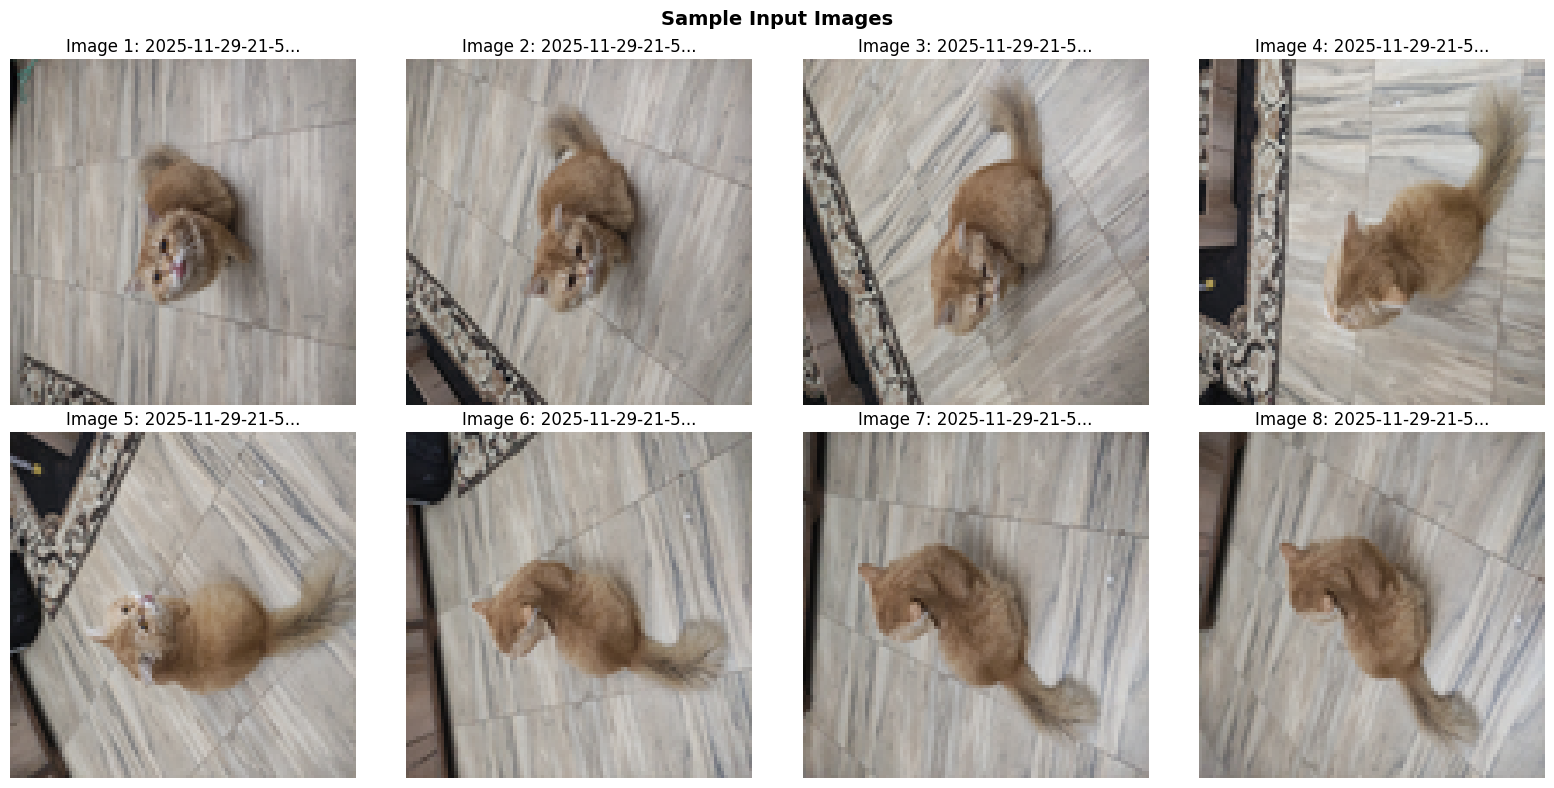

In [2]:
# ========================= LOAD CUSTOM IMAGES =========================
IMAGE_FOLDER = "Own_images"
OUTPUT_FOLDER = "nerf_output"

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Get all image files
image_files = []
valid_extensions = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}
for ext in valid_extensions:
    image_files.extend([f for f in os.listdir(IMAGE_FOLDER) if f.endswith(ext)])
image_files = sorted(image_files)

print(f"Found {len(image_files)} images in '{IMAGE_FOLDER}'")

# Load and resize images for training
TARGET_SIZE = (100, 100)  # Small size for faster training (same as tiny_nerf)

images_list = []
for img_file in image_files:
    img_path = os.path.join(IMAGE_FOLDER, img_file)
    img = Image.open(img_path).convert('RGB')
    img = img.resize(TARGET_SIZE, Image.LANCZOS)
    images_list.append(np.array(img) / 255.0)

images = np.array(images_list, dtype=np.float32)
H, W = images.shape[1:3]

print(f"Loaded {len(images)} images with shape: {images.shape}")
print(f"Image size: {H}x{W}")

# Display sample images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        ax.imshow(images[idx])
        ax.set_title(f"Image {idx+1}: {image_files[idx][:15]}...")
        ax.axis('off')
plt.suptitle('Sample Input Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/sample_images.png", dpi=150)
plt.show()

In [3]:
# ========================= AUTOMATIC CAMERA POSE ESTIMATION =========================
# This function automatically estimates camera poses using OpenCV feature matching
# It simulates what COLMAP does - finding correspondences and estimating relative poses

def estimate_camera_poses_auto(images, focal_estimate=None):
    """
    Automatically estimate camera poses using feature matching.
    Uses ORB features and Essential Matrix decomposition.
    """
    n_images = len(images)
    H, W = images[0].shape[:2]

    # Estimate focal length if not provided (assume typical camera)
    if focal_estimate is None:
        focal = max(H, W) * 1.2
    else:
        focal = focal_estimate

    # Camera intrinsic matrix
    K = np.array([
        [focal, 0, W/2],
        [0, focal, H/2],
        [0, 0, 1]
    ], dtype=np.float32)

    # Initialize poses (first camera at origin)
    poses = [np.eye(4, dtype=np.float32)]

    # ORB feature detector
    orb = cv2.ORB_create(nfeatures=1000)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    print("Estimating camera poses using feature matching...")

    # Convert images to uint8 for OpenCV
    images_uint8 = [(img * 255).astype(np.uint8) for img in images]

    # Estimate relative poses between consecutive images
    for i in tqdm(range(1, n_images)):
        img1 = cv2.cvtColor(images_uint8[i-1], cv2.COLOR_RGB2GRAY)
        img2 = cv2.cvtColor(images_uint8[i], cv2.COLOR_RGB2GRAY)

        # Detect and compute features
        kp1, des1 = orb.detectAndCompute(img1, None)
        kp2, des2 = orb.detectAndCompute(img2, None)

        if des1 is None or des2 is None or len(kp1) < 10 or len(kp2) < 10:
            # Not enough features, use incremental rotation
            angle = 2 * np.pi * i / n_images
            R = Rotation.from_euler('y', angle).as_matrix()
            t = np.array([np.sin(angle) * 4, 0, -np.cos(angle) * 4 + 4])
            T = np.eye(4, dtype=np.float32)
            T[:3, :3] = R
            T[:3, 3] = t
            poses.append(T)
            continue

        # Match features
        matches = bf.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)

        if len(matches) < 8:
            # Not enough matches, use incremental rotation
            angle = 2 * np.pi * i / n_images
            R = Rotation.from_euler('y', angle).as_matrix()
            t = np.array([np.sin(angle) * 4, 0, -np.cos(angle) * 4 + 4])
            T = np.eye(4, dtype=np.float32)
            T[:3, :3] = R
            T[:3, 3] = t
            poses.append(T)
            continue

        # Get matched points
        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

        # Find Essential Matrix
        E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

        if E is None:
            angle = 2 * np.pi * i / n_images
            R = Rotation.from_euler('y', angle).as_matrix()
            t = np.array([np.sin(angle) * 4, 0, -np.cos(angle) * 4 + 4])
            T = np.eye(4, dtype=np.float32)
            T[:3, :3] = R
            T[:3, 3] = t
            poses.append(T)
            continue

        # Recover pose from Essential Matrix
        _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)

        # Build transformation matrix
        T_rel = np.eye(4, dtype=np.float32)
        T_rel[:3, :3] = R
        T_rel[:3, 3] = t.flatten()

        # Chain with previous pose
        T_abs = poses[-1] @ T_rel
        poses.append(T_abs)

    poses = np.array(poses, dtype=np.float32)

    # Normalize poses to center around origin
    center = np.mean(poses[:, :3, 3], axis=0)
    for i in range(len(poses)):
        poses[i, :3, 3] -= center

    # Scale to reasonable range
    max_dist = np.max(np.linalg.norm(poses[:, :3, 3], axis=1))
    if max_dist > 0:
        scale = 4.0 / max_dist
        for i in range(len(poses)):
            poses[i, :3, 3] *= scale

    print(f"✓ Estimated {len(poses)} camera poses")

    return poses[:, :3, :4], focal

# Estimate poses automatically
poses, focal = estimate_camera_poses_auto(images)
print(f"\nCamera Parameters:")
print(f"  Focal Length: {focal:.2f}")
print(f"  Image Size: {H}x{W}")
print(f"  Number of Poses: {len(poses)}")

Estimating camera poses using feature matching...


100%|██████████| 14/14 [00:00<00:00, 29.60it/s]

✓ Estimated 15 camera poses

Camera Parameters:
  Focal Length: 120.00
  Image Size: 100x100
  Number of Poses: 15


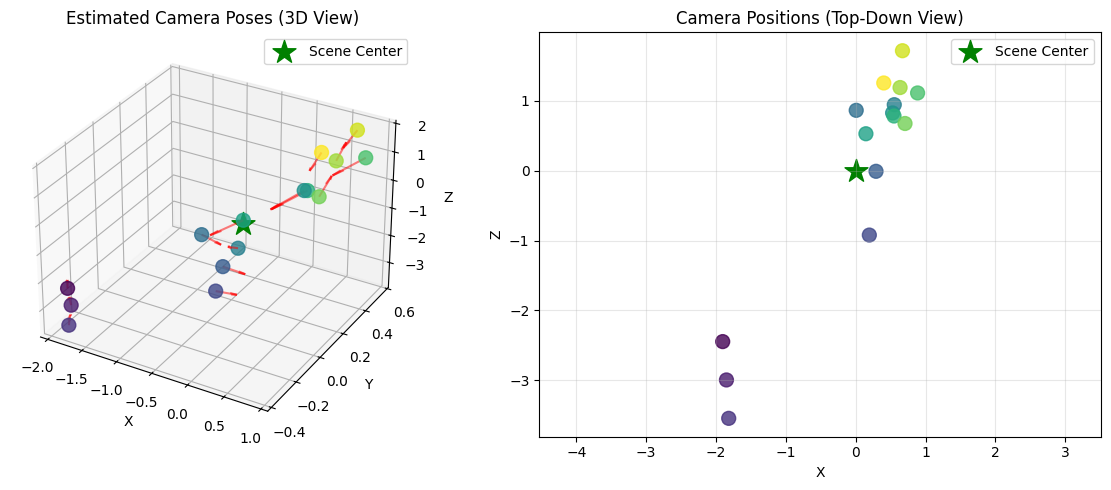

✓ Camera poses estimated and visualized


In [4]:
# ========================= VISUALIZE CAMERA POSES =========================
# Visualize the estimated camera poses in 3D

fig = plt.figure(figsize=(12, 5))

# 3D View
ax1 = fig.add_subplot(121, projection='3d')
camera_positions = poses[:, :3, 3]
ax1.scatter(camera_positions[:, 0], camera_positions[:, 1], camera_positions[:, 2],
           c=range(len(camera_positions)), cmap='viridis', s=100, alpha=0.8)

# Draw camera orientations
for i, pose in enumerate(poses):
    pos = pose[:3, 3]
    forward = pose[:3, 2] * 0.3  # Z-axis (viewing direction)
    ax1.quiver(pos[0], pos[1], pos[2], forward[0], forward[1], forward[2],
              color='red', alpha=0.5, arrow_length_ratio=0.3)

ax1.scatter(0, 0, 0, c='green', marker='*', s=300, label='Scene Center')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Estimated Camera Poses (3D View)')
ax1.legend()

# Top-down view
ax2 = fig.add_subplot(122)
ax2.scatter(camera_positions[:, 0], camera_positions[:, 2],
           c=range(len(camera_positions)), cmap='viridis', s=100, alpha=0.8)
ax2.scatter(0, 0, c='green', marker='*', s=300, label='Scene Center')
ax2.set_xlabel('X')
ax2.set_ylabel('Z')
ax2.set_title('Camera Positions (Top-Down View)')
ax2.axis('equal')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/camera_poses.png", dpi=150)
plt.show()

print(f"✓ Camera poses estimated and visualized")

# Step 2: Define NeRF Model
Define the Tiny NeRF architecture with positional encoding and volume rendering.

In [7]:
# ========================= NERF MODEL DEFINITION =========================
# Positional Encoding

L_embed = 6  # Number of frequency bands for positional encoding

def posenc(x):
    """Positional encoding for input coordinates"""
    rets = [x]
    for i in range(L_embed):
        for fn in [tf.sin, tf.cos]:
            rets.append(fn(2.**i * x))
    return tf.concat(rets, -1)

embed_fn = posenc

def init_model(D=8, W=256):
    """Initialize the NeRF MLP model"""
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu: tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed,))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i % 4 == 0 and i > 0:
            # Use Keras Concatenate layer instead of tf.concat
            outputs = tf.keras.layers.Concatenate()([outputs, inputs])
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def get_rays(H, W, focal, c2w):
    """Generate rays for each pixel given camera pose"""
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32),
                       tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i - W * 0.5) / focal,
                     -(j - H * 0.5) / focal,
                     -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3, :3], -1)
    rays_o = tf.broadcast_to(c2w[:3, -1], tf.shape(rays_d))
    return rays_o, rays_d

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    """Volume rendering along rays"""
    def batchify(fn, chunk=1024*32):
        return lambda inputs: tf.concat([fn(inputs[i:i+chunk])
                                         for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far - near) / N_samples
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

    # Run network
    pts_flat = tf.reshape(pts, [-1, 3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[..., 3])
    rgb = tf.math.sigmoid(raw[..., :3])

    # Volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1],
                       tf.broadcast_to([1e10], z_vals[..., :1].shape)], -1)
    alpha = 1. - tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1. - alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[..., None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

print("✓ NeRF model functions defined")
print(f"  Positional encoding levels: {L_embed}")
print(f"  Input dimension: {3 + 3*2*L_embed}")

✓ NeRF model functions defined
  Positional encoding levels: 6
  Input dimension: 39


# Step 3: Train NeRF Model
Train the NeRF model on the custom images with automatically estimated camera poses. We plot the rendered view and PSNR during training.

Training NeRF on 14 images...
Test image: Image 15
Near: 2.0, Far: 6.0
Samples per ray: 64
--------------------------------------------------
Iter    0 | Loss: 0.310748 | PSNR: 13.63 dB | 0.12s/iter


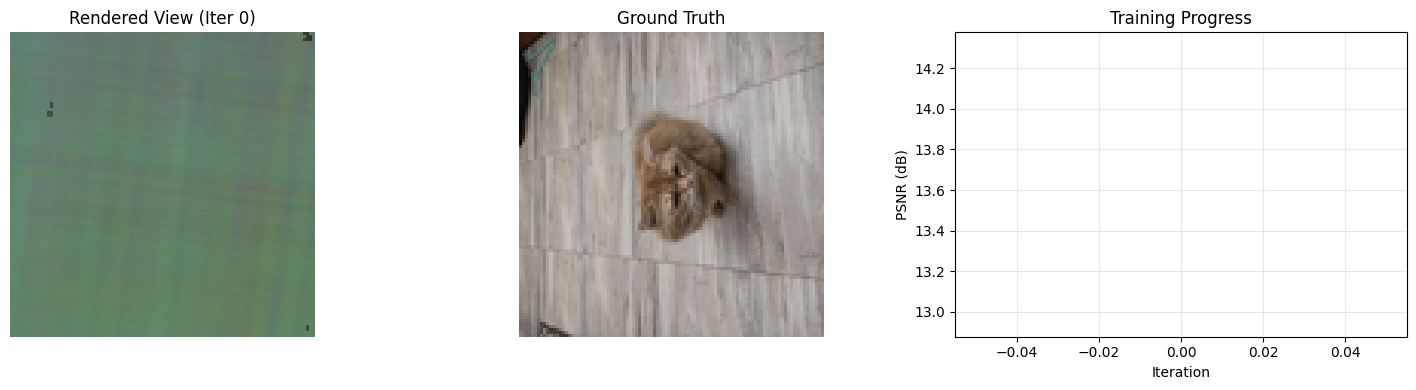

Iter   50 | Loss: 0.050795 | PSNR: 18.03 dB | 0.71s/iter


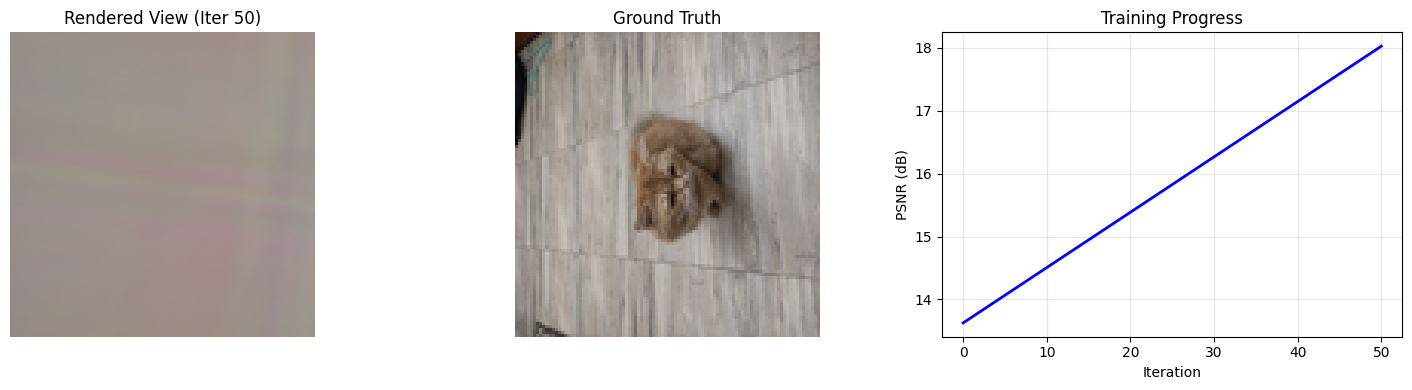

Iter  100 | Loss: 0.030788 | PSNR: 17.23 dB | 0.74s/iter


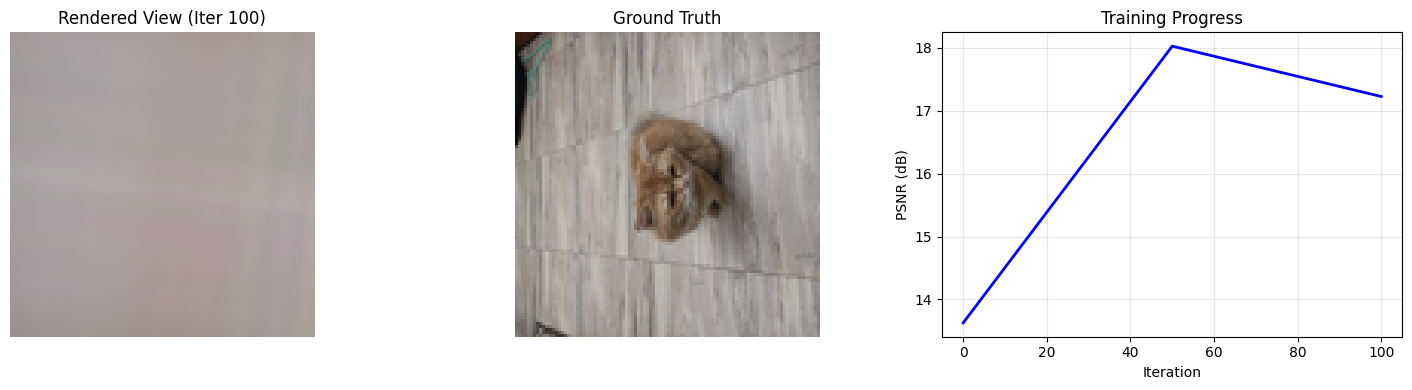

Iter  150 | Loss: 0.020763 | PSNR: 12.56 dB | 0.74s/iter


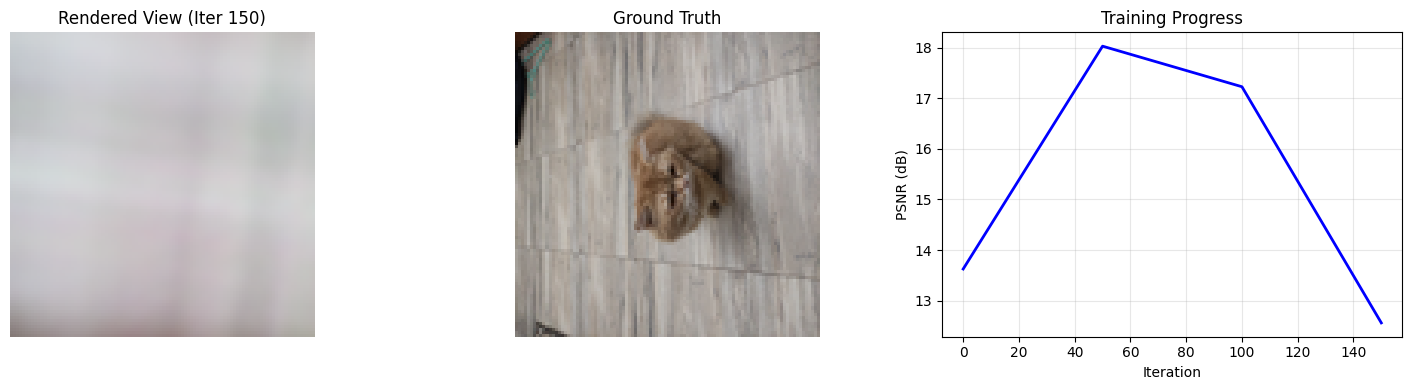

Iter  200 | Loss: 0.020980 | PSNR: 17.61 dB | 0.74s/iter


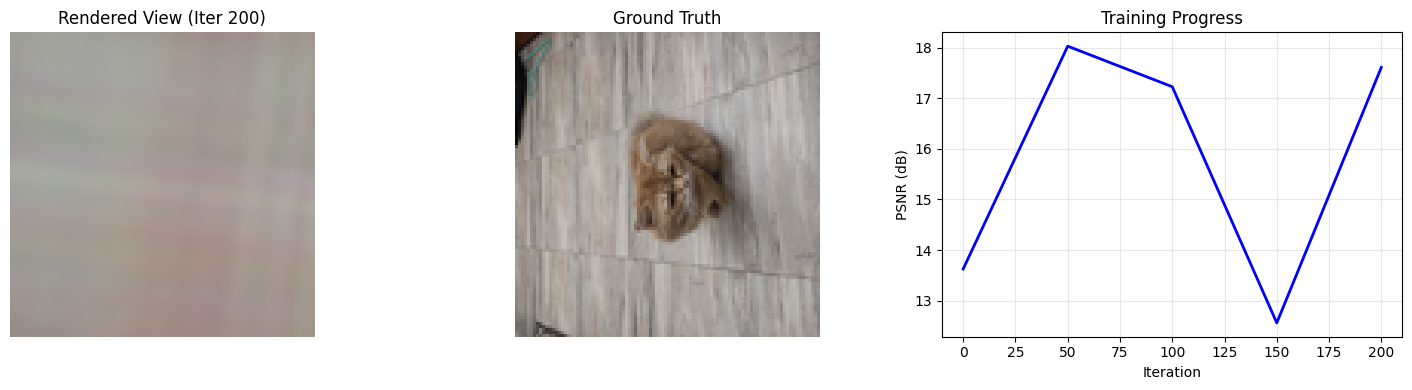

Iter  250 | Loss: 0.017209 | PSNR: 16.93 dB | 0.74s/iter


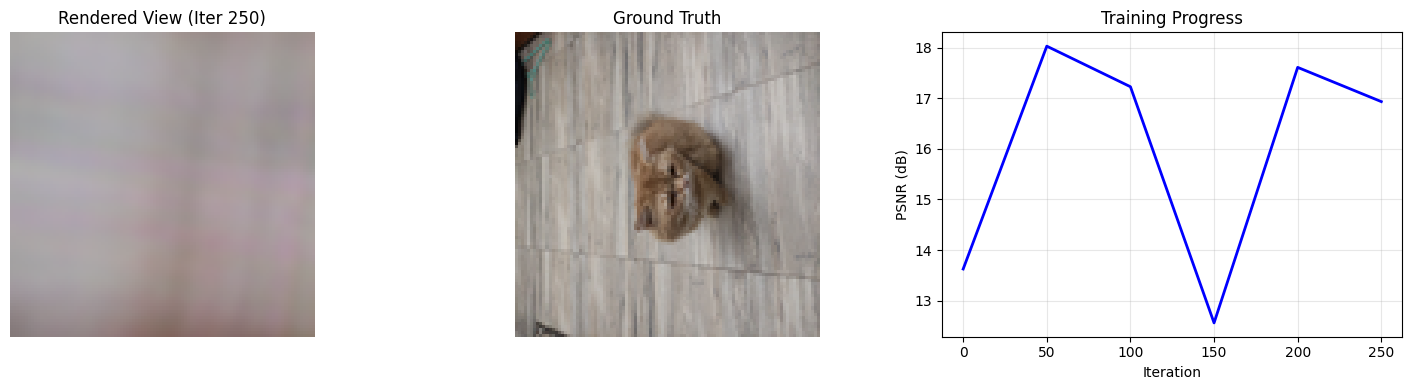

Iter  300 | Loss: 0.012195 | PSNR: 14.50 dB | 0.74s/iter


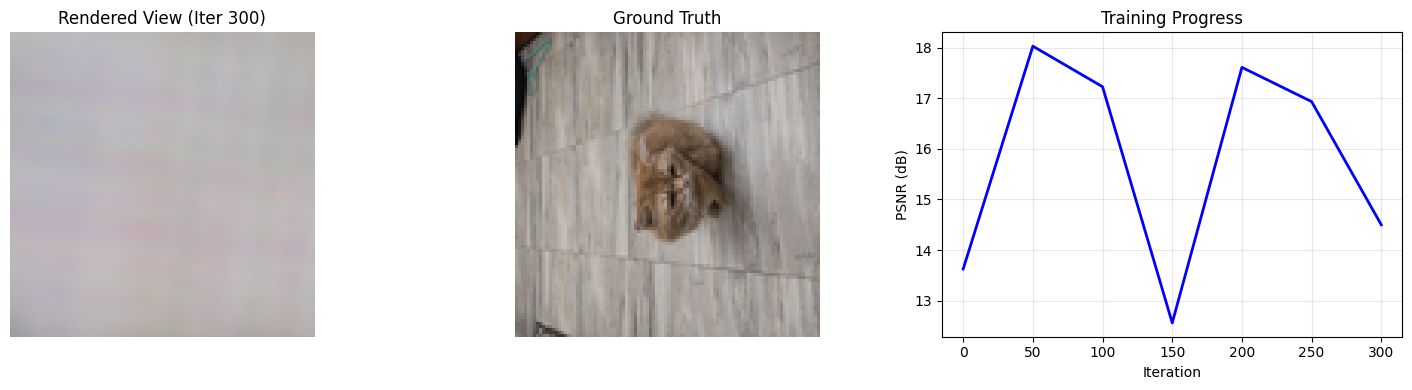

Iter  350 | Loss: 0.017389 | PSNR: 14.50 dB | 0.74s/iter


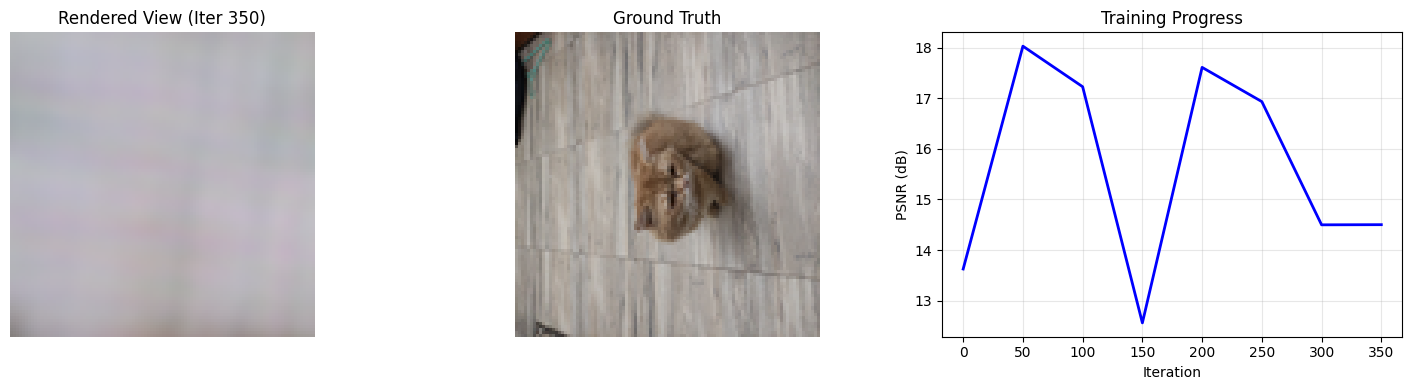

Iter  400 | Loss: 0.010719 | PSNR: 16.64 dB | 0.74s/iter


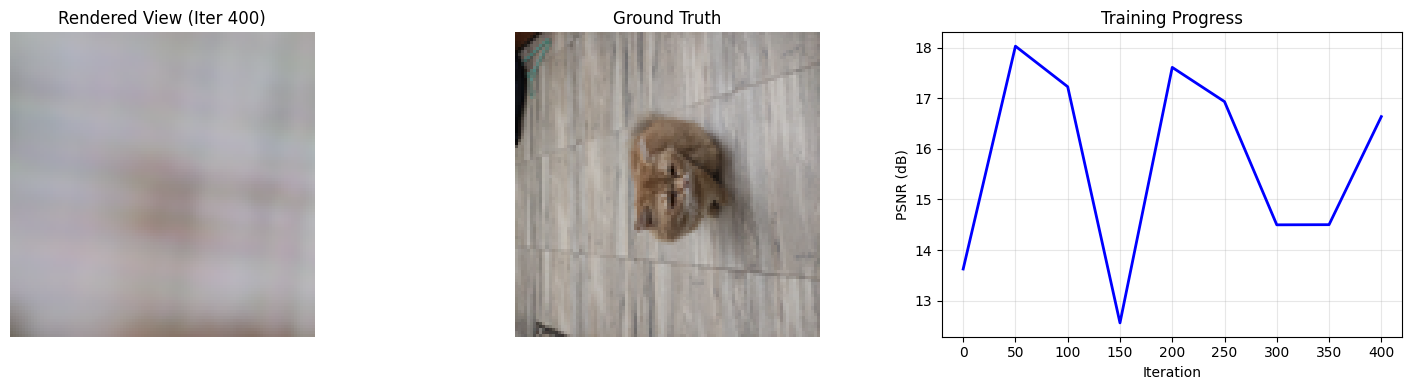

Iter  450 | Loss: 0.009525 | PSNR: 17.35 dB | 0.75s/iter


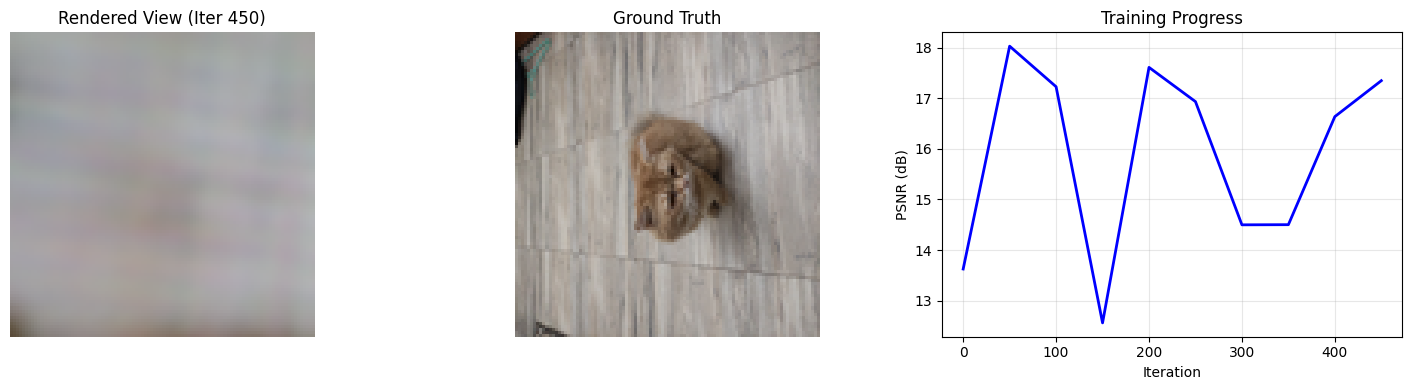

Iter  500 | Loss: 0.011525 | PSNR: 15.24 dB | 0.74s/iter


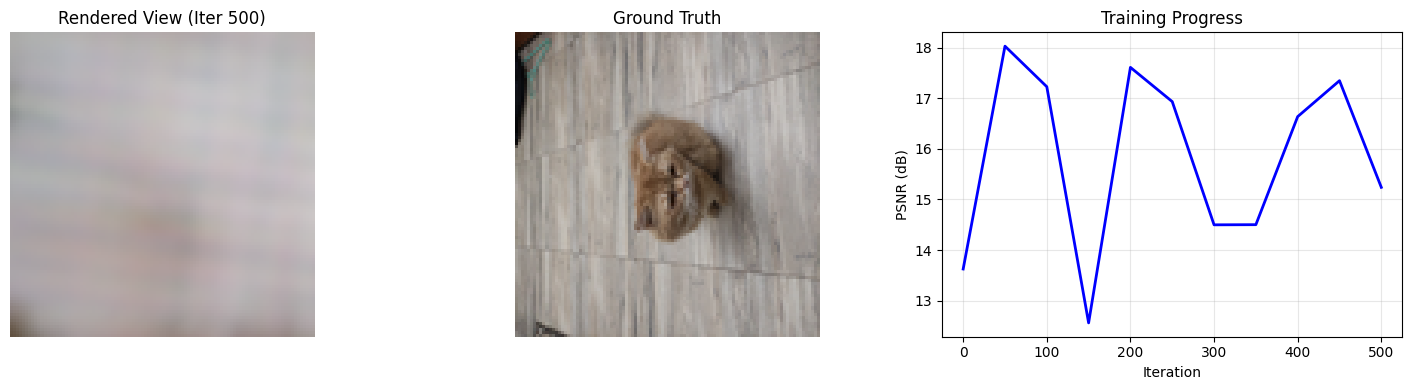

Iter  550 | Loss: 0.007849 | PSNR: 16.24 dB | 0.75s/iter


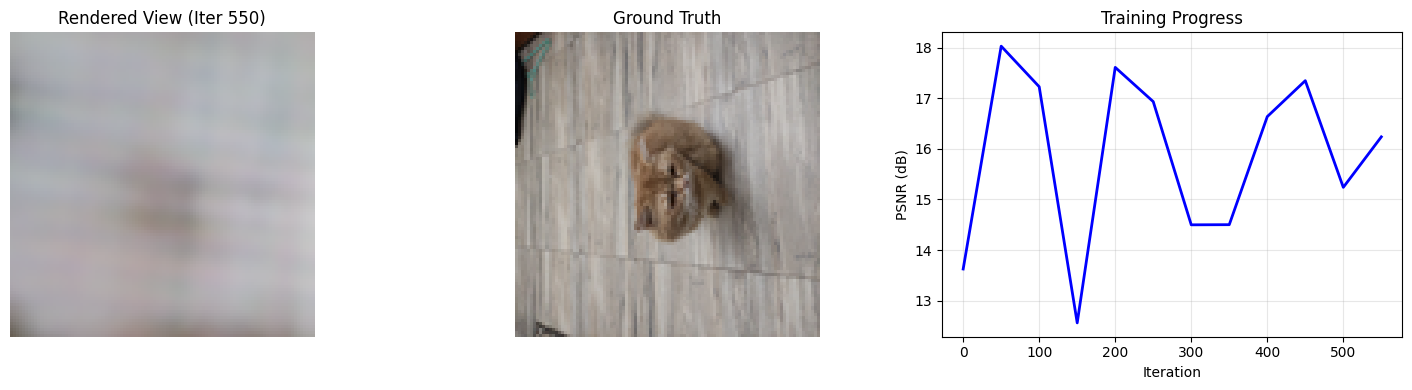

Iter  600 | Loss: 0.006704 | PSNR: 15.30 dB | 0.74s/iter


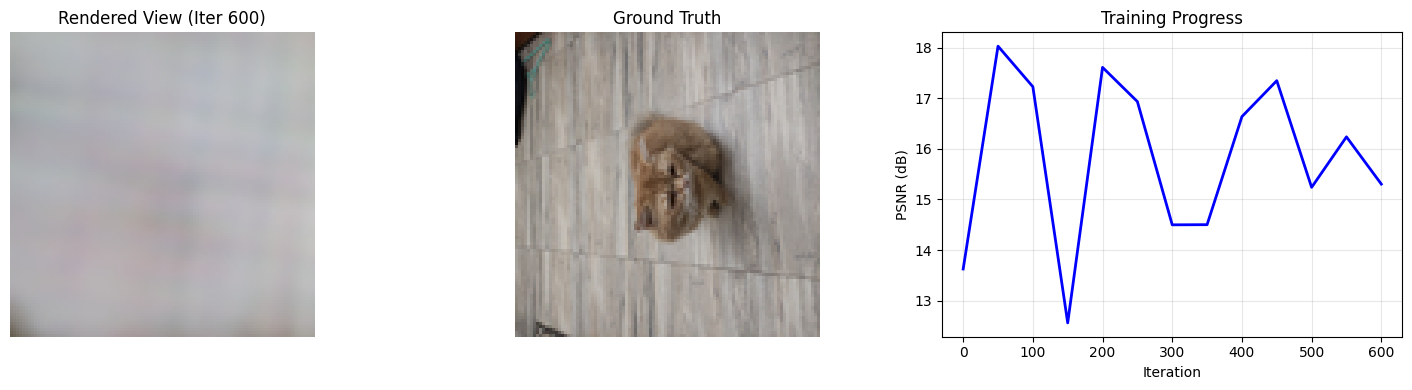

Iter  650 | Loss: 0.007841 | PSNR: 17.38 dB | 0.74s/iter


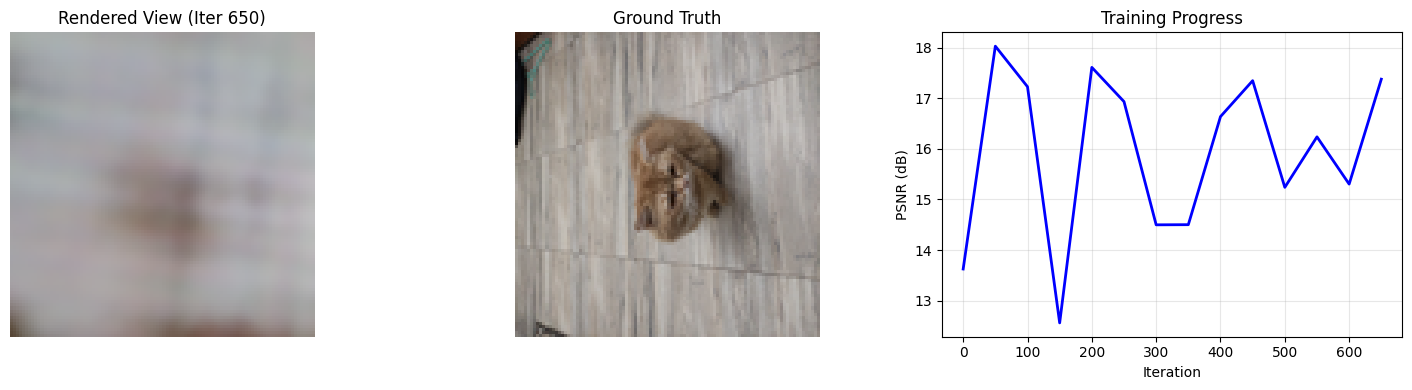

Iter  700 | Loss: 0.009525 | PSNR: 15.25 dB | 0.74s/iter


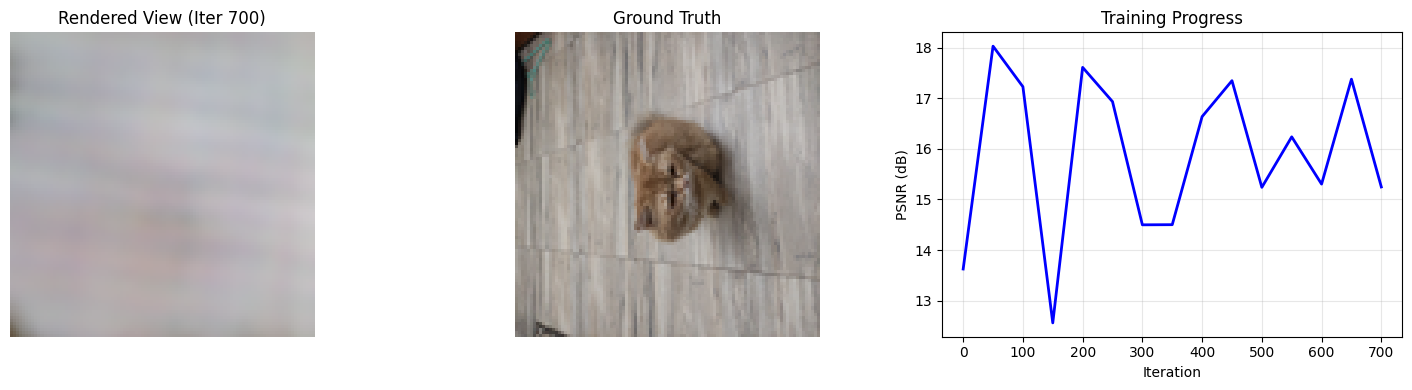

Iter  750 | Loss: 0.009091 | PSNR: 16.12 dB | 0.74s/iter


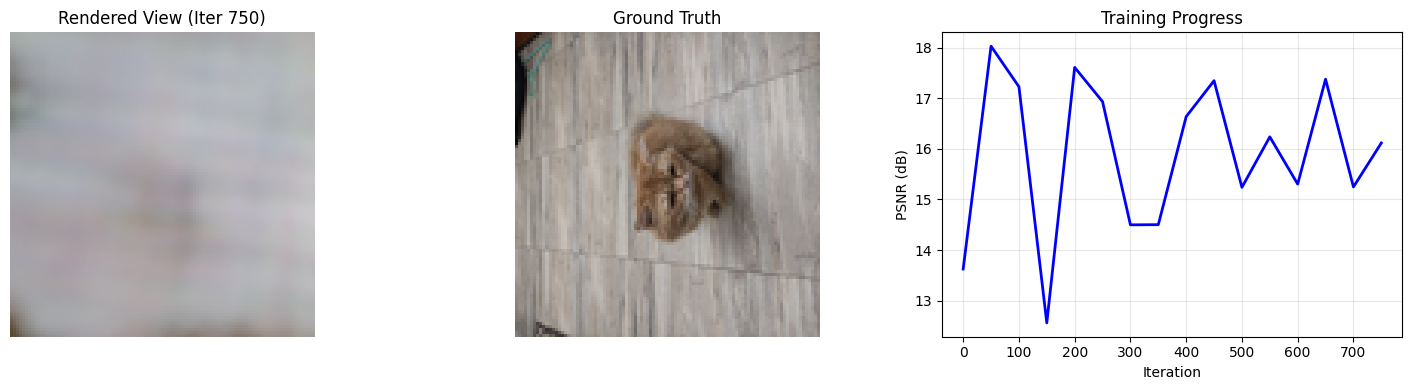

Iter  800 | Loss: 0.005876 | PSNR: 16.74 dB | 0.74s/iter


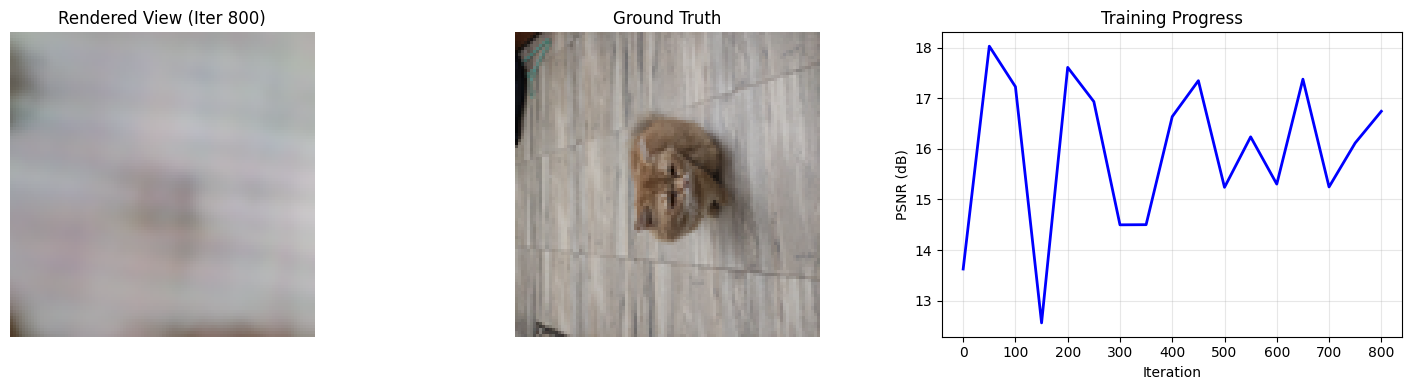

Iter  850 | Loss: 0.009017 | PSNR: 17.62 dB | 0.74s/iter


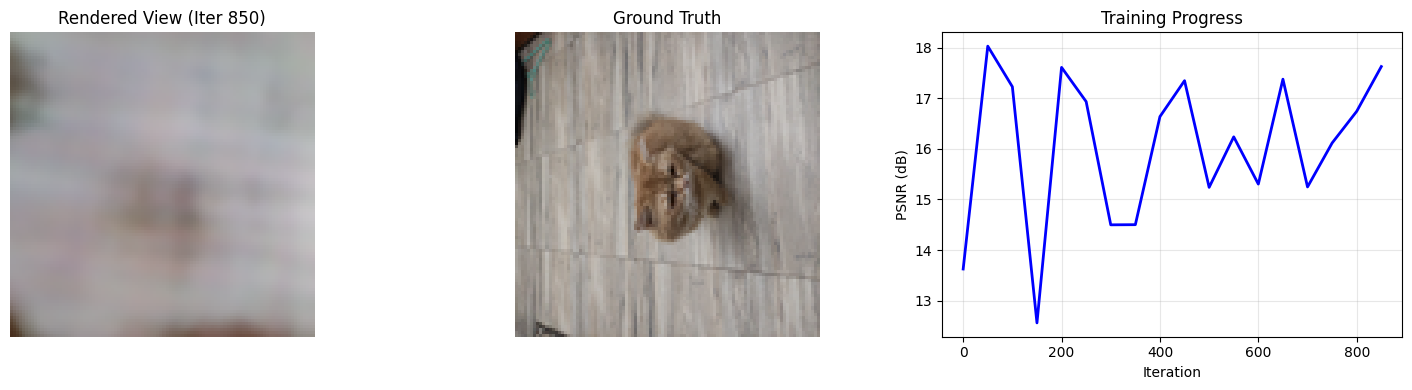

Iter  900 | Loss: 0.007297 | PSNR: 17.02 dB | 0.74s/iter


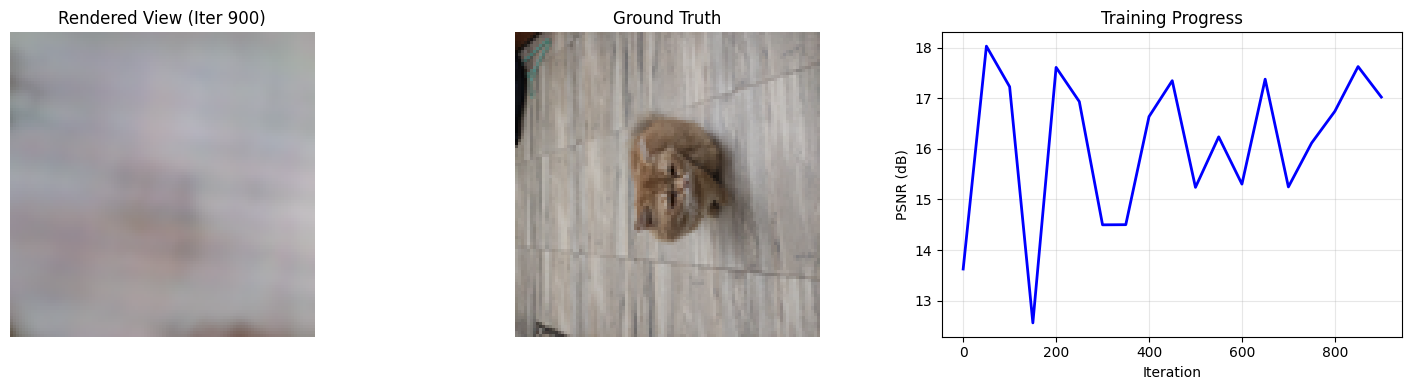

Iter  950 | Loss: 0.007713 | PSNR: 17.58 dB | 0.75s/iter


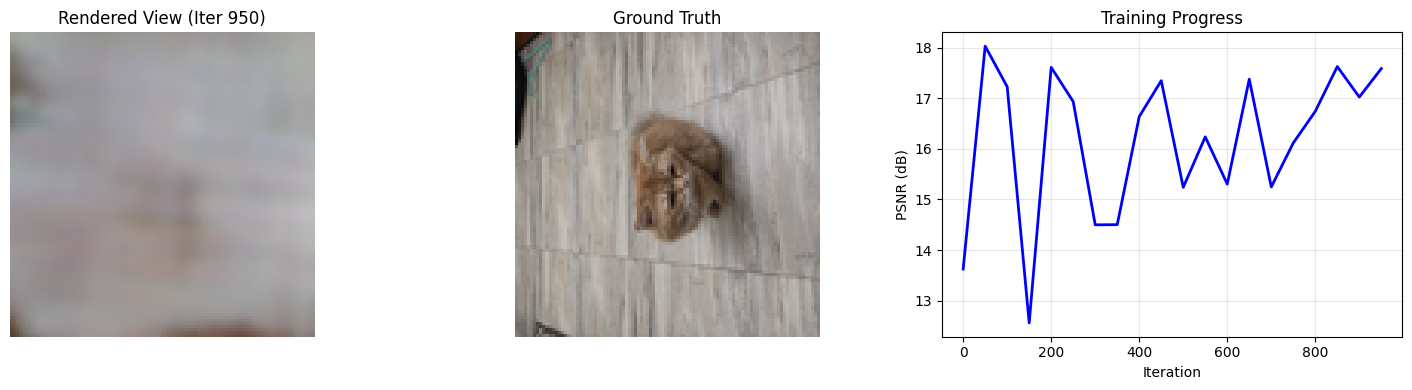

Iter 1000 | Loss: 0.008023 | PSNR: 15.94 dB | 0.75s/iter


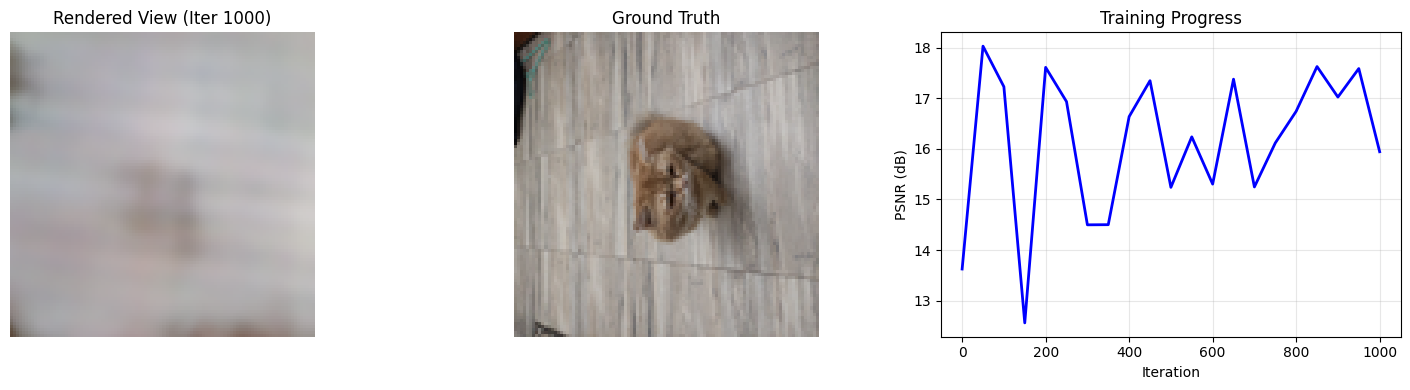

--------------------------------------------------
✓ Training completed! Final PSNR: 15.94 dB


In [8]:
# ========================= TRAIN NERF MODEL =========================
# Initialize model and optimizer
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

# Training parameters
N_samples = 64  # Number of samples per ray
N_iters = 1000  # Number of training iterations
i_plot = 50     # Plot every i_plot iterations

# Use last image as test
n_train = len(images) - 1
testimg = images[-1]
testpose = poses[-1]
train_images = images[:n_train]
train_poses = poses[:n_train]

# Near and far bounds (adjust based on your scene)
near = 2.0
far = 6.0

# Training metrics
psnrs = []
iternums = []
losses_history = []

import time
print(f"Training NeRF on {n_train} images...")
print(f"Test image: Image {len(images)}")
print(f"Near: {near}, Far: {far}")
print(f"Samples per ray: {N_samples}")
print("-" * 50)

t = time.time()
for i in range(N_iters + 1):
    # Random training image
    img_i = np.random.randint(train_images.shape[0])
    target = train_images[img_i]
    pose = train_poses[img_i]

    # Get rays for this image
    rays_o, rays_d = get_rays(H, W, focal, pose)

    # Training step
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d,
                                       near=near, far=far,
                                       N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    losses_history.append(loss.numpy())

    # Logging and visualization
    if i % i_plot == 0:
        elapsed = (time.time() - t) / max(i_plot, 1)
        t = time.time()

        # Render test view
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d,
                                       near=near, far=far, N_samples=N_samples)
        test_loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(test_loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        print(f"Iter {i:4d} | Loss: {loss.numpy():.6f} | PSNR: {psnr.numpy():.2f} dB | {elapsed:.2f}s/iter")

        # Visualize progress
        plt.figure(figsize=(15, 4))

        plt.subplot(131)
        plt.imshow(np.clip(rgb.numpy(), 0, 1))
        plt.title(f'Rendered View (Iter {i})')
        plt.axis('off')

        plt.subplot(132)
        plt.imshow(testimg)
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(133)
        plt.plot(iternums, psnrs, 'b-', linewidth=2)
        plt.xlabel('Iteration')
        plt.ylabel('PSNR (dB)')
        plt.title('Training Progress')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

print("-" * 50)
print(f"✓ Training completed! Final PSNR: {psnrs[-1]:.2f} dB")

# Step 4: Interactive Visualization
Use interactive sliders to explore the learned 3D scene from different viewpoints.

In [10]:
# ========================= INTERACTIVE VISUALIZATION =========================
%matplotlib inline
from ipywidgets import interactive, widgets

# Camera pose generation functions for novel views
trans_t = lambda t: tf.convert_to_tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, t],
    [0, 0, 0, 1],
], dtype=tf.float32)

rot_phi = lambda phi: tf.convert_to_tensor([
    [1, 0, 0, 0],
    [0, tf.cos(phi), -tf.sin(phi), 0],
    [0, tf.sin(phi), tf.cos(phi), 0],
    [0, 0, 0, 1],
], dtype=tf.float32)

rot_theta = lambda th: tf.convert_to_tensor([
    [tf.cos(th), 0, -tf.sin(th), 0],
    [0, 1, 0, 0],
    [tf.sin(th), 0, tf.cos(th), 0],
    [0, 0, 0, 1],
], dtype=tf.float32)

def pose_spherical(theta, phi, radius):
    """Generate camera pose on a sphere looking at origin"""
    c2w = trans_t(radius)
    c2w = rot_phi(phi / 180. * np.pi) @ c2w
    c2w = rot_theta(theta / 180. * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w

def render_view(**kwargs):
    """Render a view from the given camera parameters"""
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3, :4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d,
                                   near=near, far=far, N_samples=N_samples)
    img = np.clip(rgb.numpy(), 0, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(f"θ={kwargs['theta']:.0f}°, φ={kwargs['phi']:.0f}°, r={kwargs['radius']:.1f}")
    plt.axis('off')
    plt.show()

# Create interactive sliders
slider = lambda v, mi, ma: widgets.FloatSlider(value=v, min=mi, max=ma, step=1.0)

names = [
    ['theta', [0., 0., 360.]],   # Horizontal rotation
    ['phi', [-30., -90., 0.]],   # Vertical angle
    ['radius', [4., 2., 6.]],    # Distance from center
]

print("Use the sliders to explore novel views of your scene!")
interactive_plot = interactive(render_view, **{s[0]: slider(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

Use the sliders to explore novel views of your scene!


interactive(children=(FloatSlider(value=0.0, description='theta', max=360.0, step=1.0), FloatSlider(value=-30.…

# Step 5: Generate Novel View Images
Generate images from camera angles that were **NOT** in the original capture. These are completely new viewpoints synthesized by the trained NeRF model.

Generating novel views from new camera angles...
These are viewpoints that were NOT in your original images!



Rendering novel views: 100%|██████████| 12/12 [00:03<00:00,  3.51it/s]


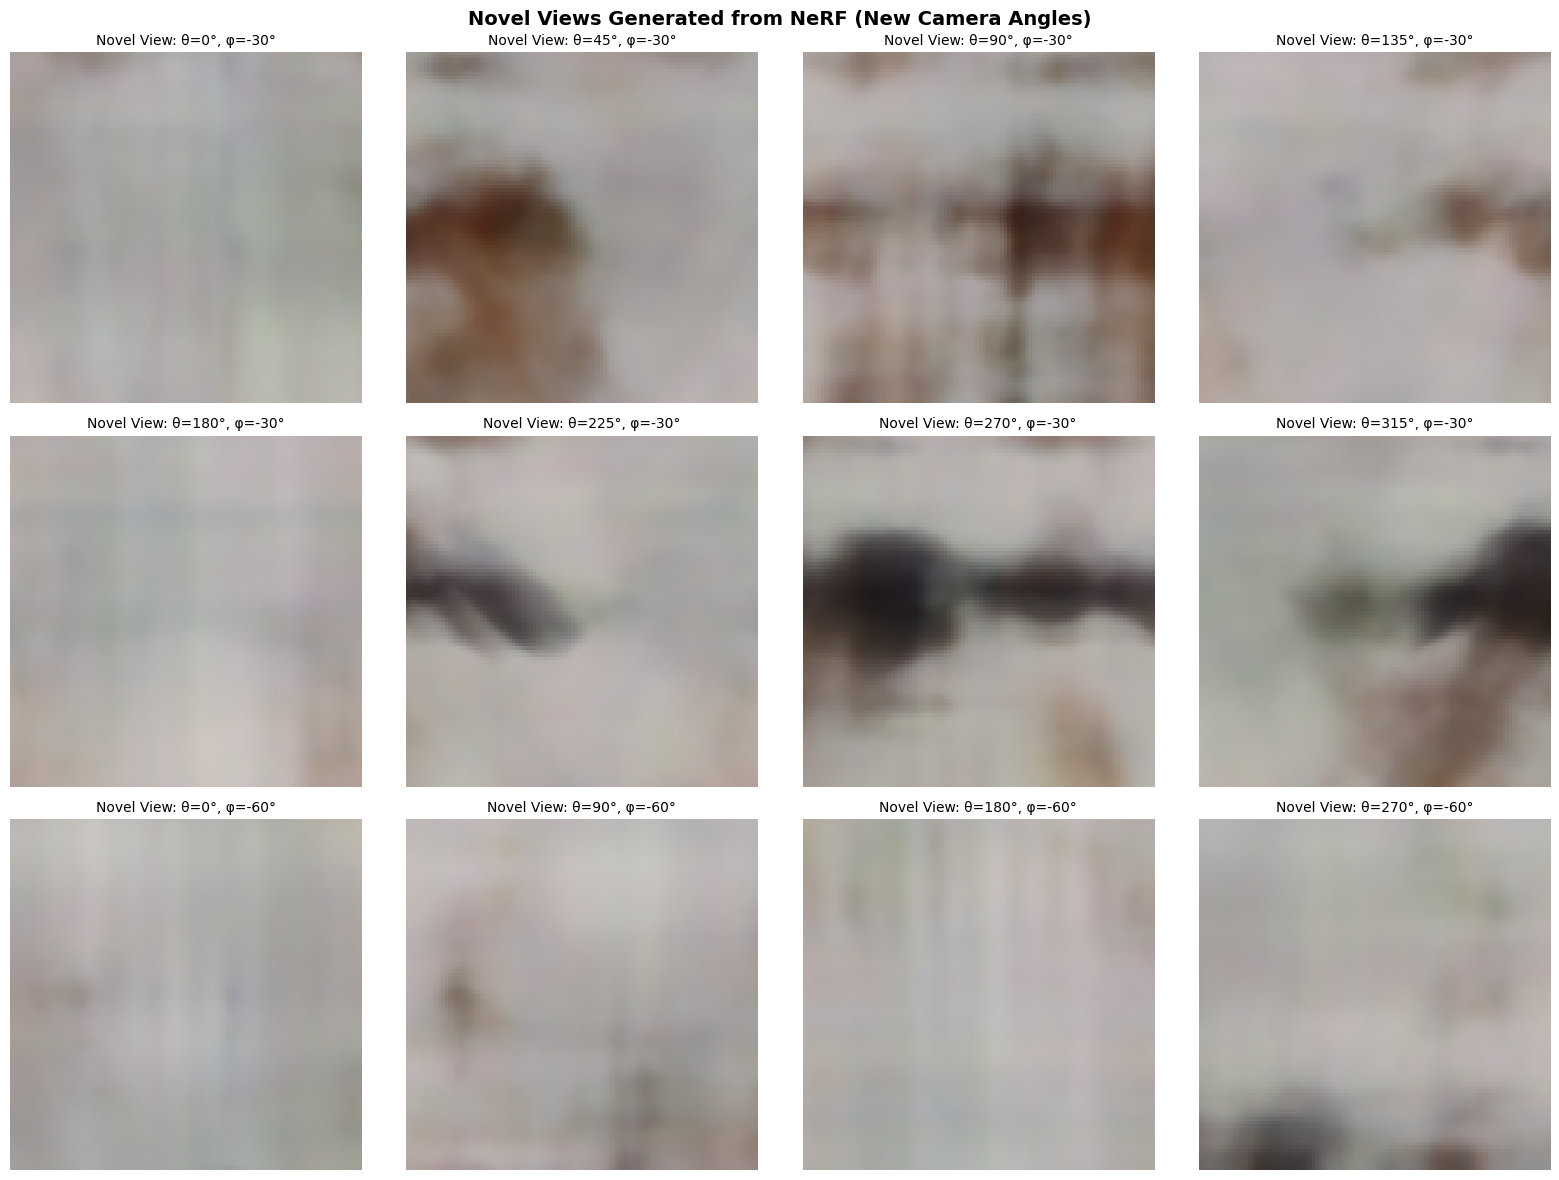


✓ Generated 12 novel views from new angles!
  Saved to: nerf_output/novel_views_grid.png


In [11]:
# ========================= GENERATE NOVEL VIEW IMAGES =========================
# Generate novel views from angles NOT in the original dataset

print("Generating novel views from new camera angles...")
print("These are viewpoints that were NOT in your original images!\n")

# Define novel viewpoints (different from training views)
novel_angles = [
    (0, -30, 4),     # Front view
    (45, -30, 4),    # Front-right
    (90, -30, 4),    # Right side
    (135, -30, 4),   # Back-right
    (180, -30, 4),   # Back view
    (225, -30, 4),   # Back-left
    (270, -30, 4),   # Left side
    (315, -30, 4),   # Front-left
    (0, -60, 4),     # Top-front view
    (90, -60, 4),    # Top-right view
    (180, -60, 4),   # Top-back view
    (270, -60, 4),   # Top-left view
]

novel_images = []
novel_depths = []

for i, (theta, phi, radius) in enumerate(tqdm(novel_angles, desc="Rendering novel views")):
    c2w = pose_spherical(theta, phi, radius)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3, :4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d,
                                   near=near, far=far, N_samples=N_samples)
    novel_images.append(np.clip(rgb.numpy(), 0, 1))
    novel_depths.append(depth.numpy())

# Display novel views in a grid
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx, ax in enumerate(axes.flat):
    if idx < len(novel_images):
        ax.imshow(novel_images[idx])
        theta, phi, radius = novel_angles[idx]
        ax.set_title(f"Novel View: θ={theta}°, φ={phi}°", fontsize=10)
        ax.axis('off')

plt.suptitle('Novel Views Generated from NeRF (New Camera Angles)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/novel_views_grid.png", dpi=150)
plt.show()

print(f"\n✓ Generated {len(novel_images)} novel views from new angles!")
print(f"  Saved to: {OUTPUT_FOLDER}/novel_views_grid.png")

# Step 6: Render 360° Video
Create a smooth 360° rotation video around the scene to showcase the NeRF reconstruction.

Rendering 360° video frames...
This may take a few minutes...



Rendering frames: 100%|██████████| 120/120 [00:35<00:00,  3.37it/s]



✓ Video saved to: nerf_output/nerf_360_video.mp4
  Total frames: 120
  Duration: 4.0 seconds


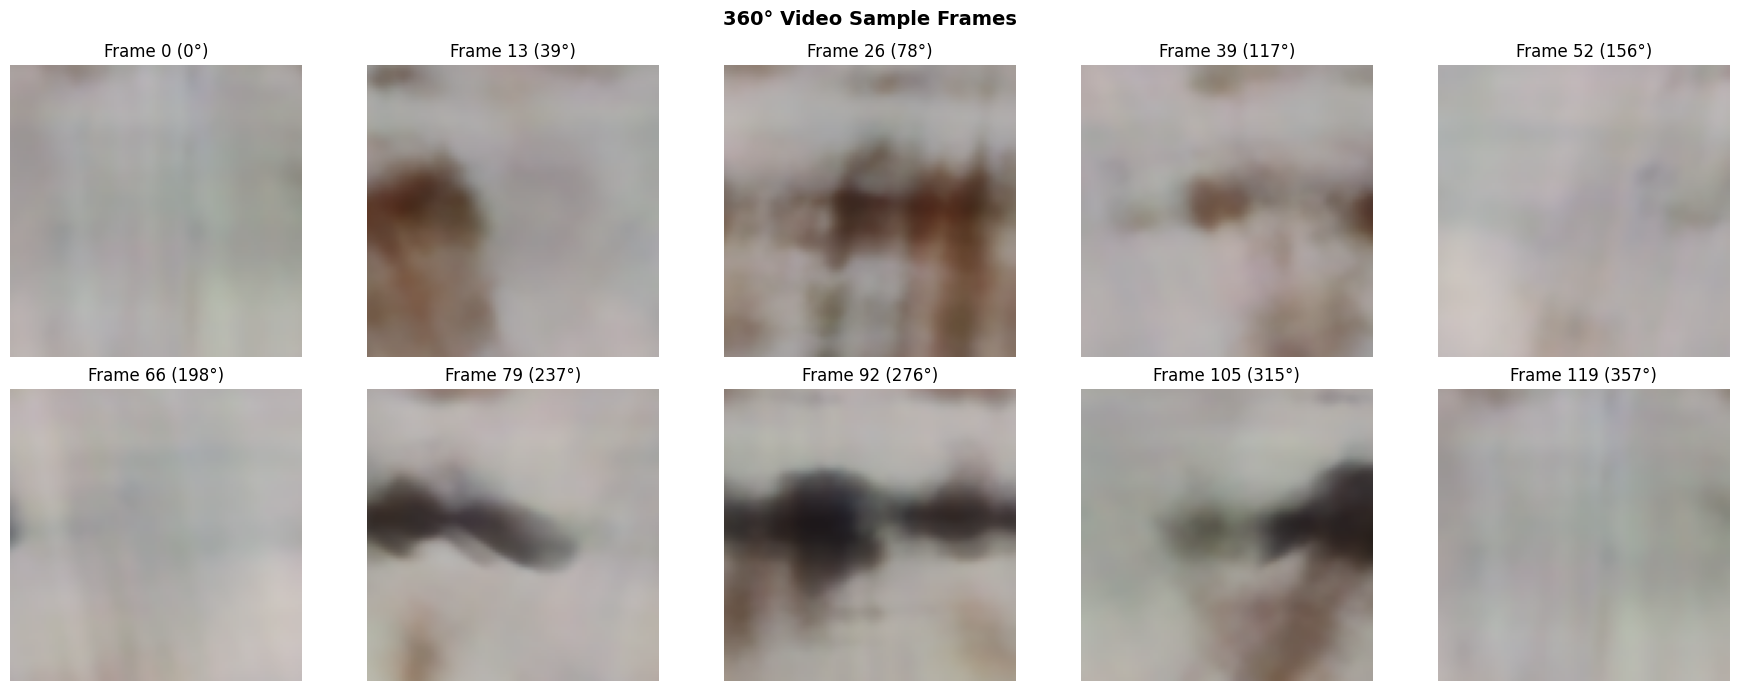

In [12]:
# ========================= RENDER 360° VIDEO =========================
# Generate frames for a smooth 360° rotation around the scene

print("Rendering 360° video frames...")
print("This may take a few minutes...\n")

n_frames = 120  # Number of frames (4 seconds at 30fps)
frames = []

for th in tqdm(np.linspace(0., 360., n_frames, endpoint=False), desc="Rendering frames"):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3, :4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d,
                                   near=near, far=far, N_samples=N_samples)
    frames.append((255 * np.clip(rgb.numpy(), 0, 1)).astype(np.uint8))

# Save video
video_path = f'{OUTPUT_FOLDER}/nerf_360_video.mp4'
imageio.mimwrite(video_path, frames, fps=30, quality=7)

print(f"\n✓ Video saved to: {video_path}")
print(f"  Total frames: {len(frames)}")
print(f"  Duration: {len(frames)/30:.1f} seconds")

# Display sample frames from the video
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
sample_indices = np.linspace(0, len(frames)-1, 10, dtype=int)
for idx, ax in enumerate(axes.flat):
    frame_idx = sample_indices[idx]
    ax.imshow(frames[frame_idx])
    ax.set_title(f"Frame {frame_idx} ({frame_idx*3}°)")
    ax.axis('off')

plt.suptitle('360° Video Sample Frames', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/video_sample_frames.png", dpi=150)
plt.show()

In [13]:
# ========================= DISPLAY VIDEO IN NOTEBOOK =========================
# Display the rendered 360° video

from IPython.display import HTML
from base64 import b64encode

# Read and encode video
mp4 = open(video_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

print("360° NeRF Video - Novel View Synthesis:")
HTML("""
<video width=500 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

360° NeRF Video - Novel View Synthesis:


# Step 7: Display Generated Images & Summary
Show all the novel view images generated by NeRF and provide a summary of the reconstruction.

NERF RECONSTRUCTION SUMMARY

Generating additional novel views...


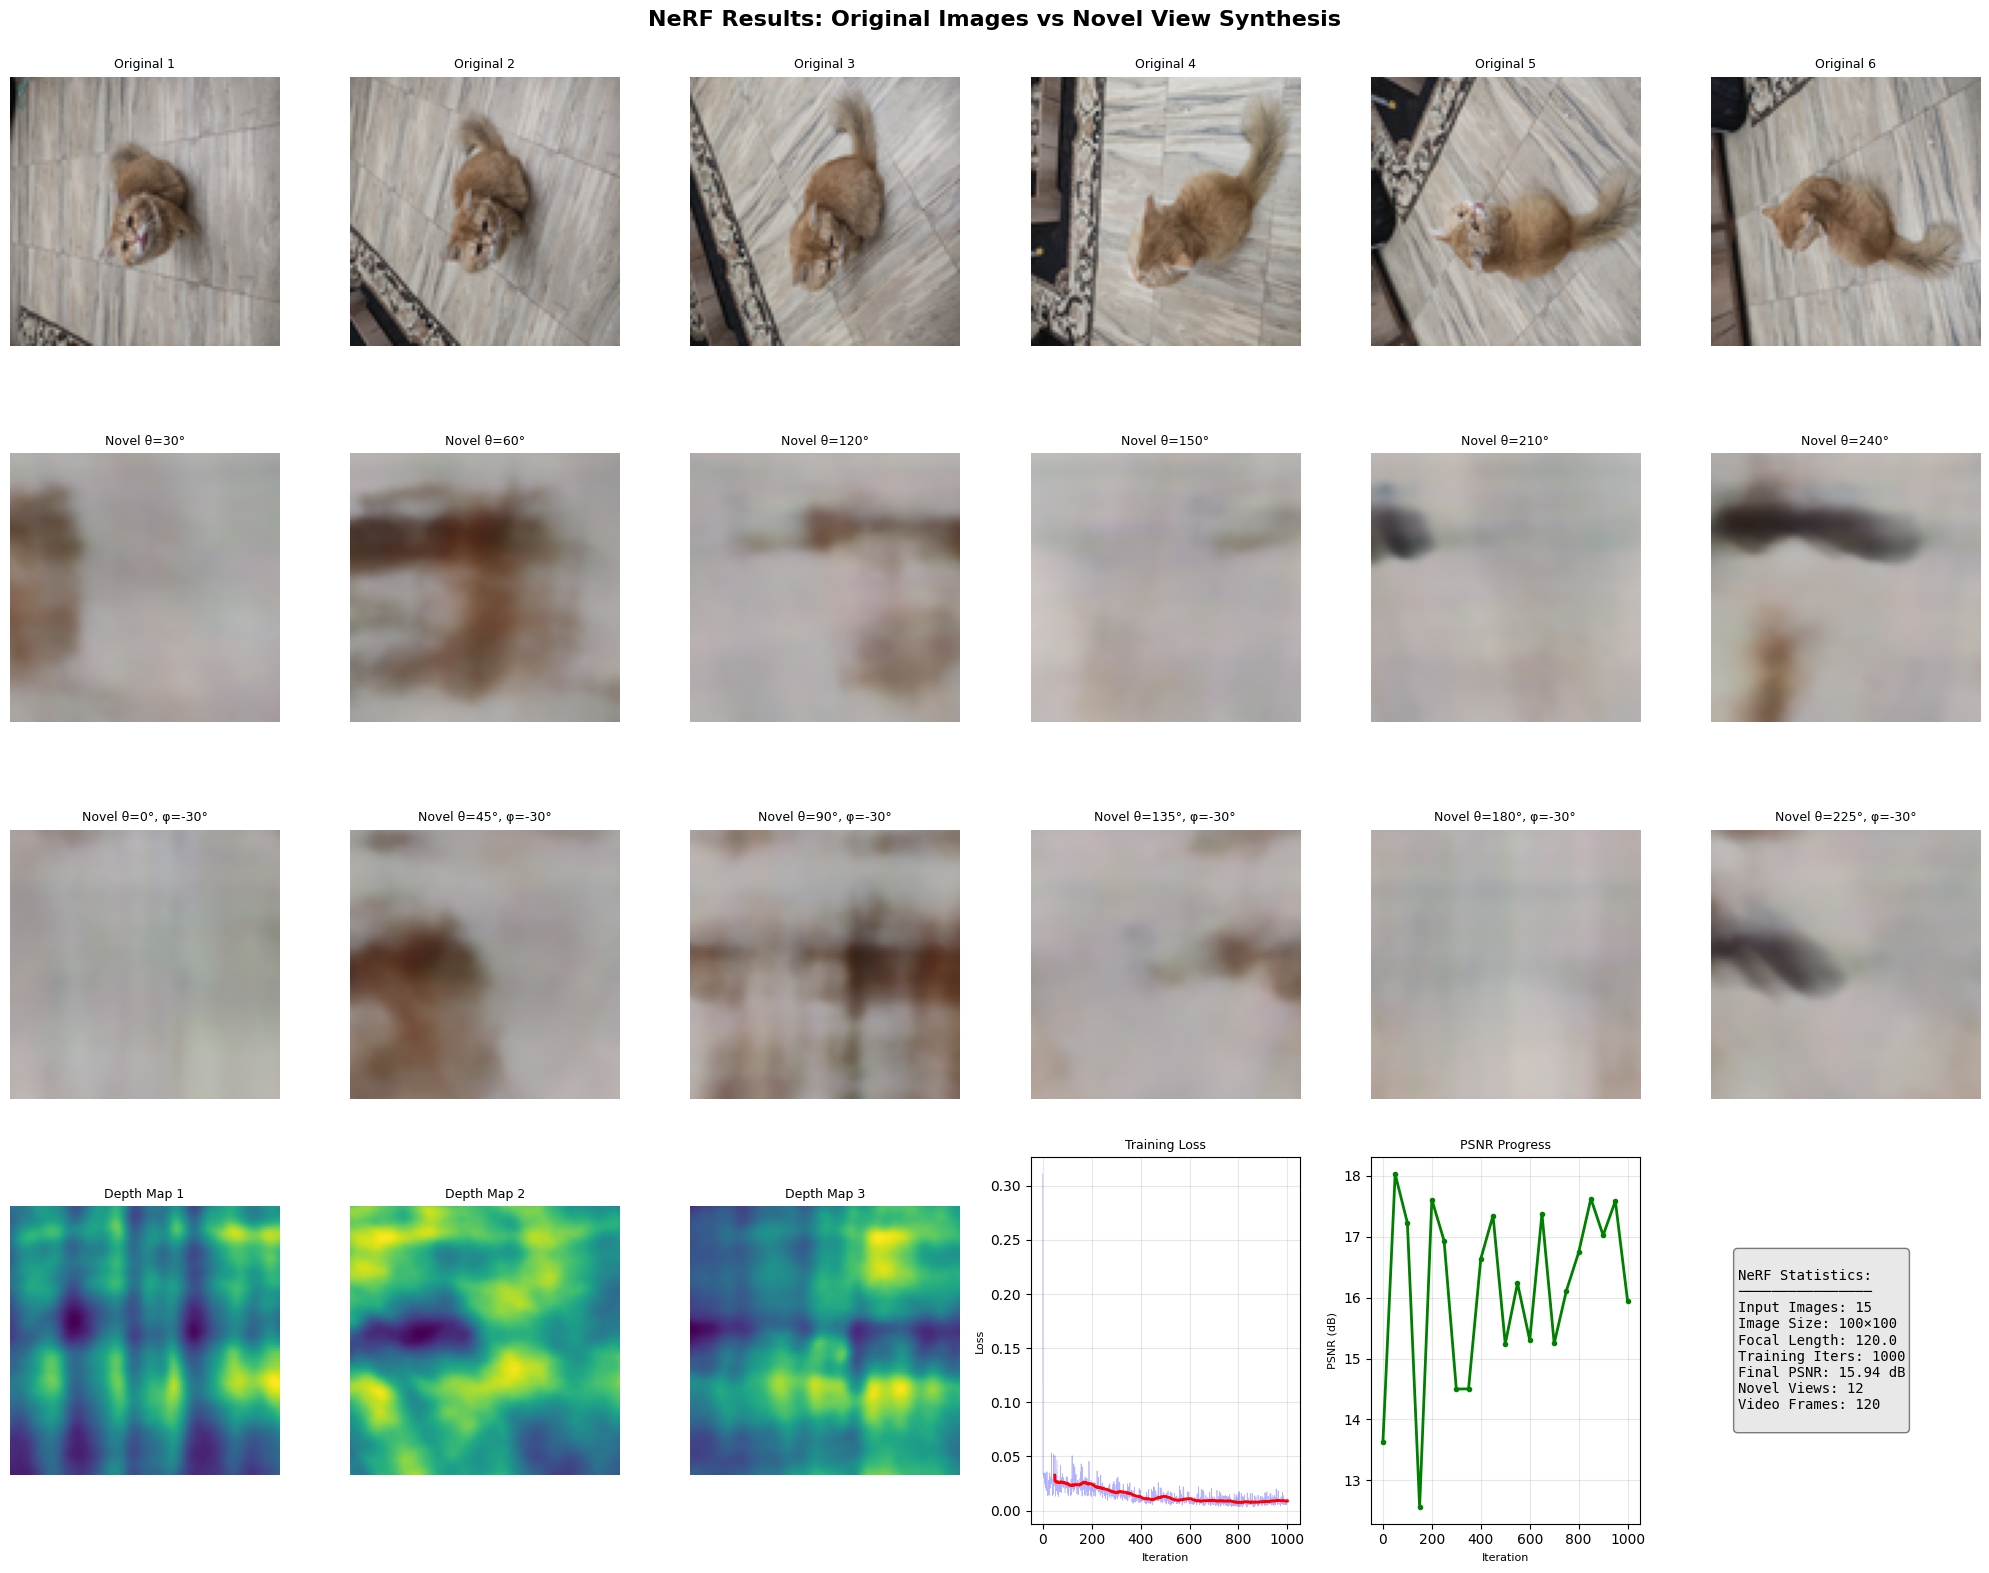

In [14]:
# ========================= DISPLAY GENERATED IMAGES & SUMMARY =========================
# Create a comprehensive visualization of original vs novel views

print("=" * 70)
print("NERF RECONSTRUCTION SUMMARY")
print("=" * 70)

# Create comparison figure
fig = plt.figure(figsize=(20, 16))

# Top row: Original input images
for i in range(min(6, len(images))):
    ax = fig.add_subplot(4, 6, i + 1)
    ax.imshow(images[i])
    ax.set_title(f"Original {i+1}", fontsize=9)
    ax.axis('off')

# Middle row: More novel views with different angles
print("\nGenerating additional novel views...")
additional_angles = [
    (30, -20, 4), (60, -20, 4), (120, -20, 4),
    (150, -20, 4), (210, -20, 4), (240, -20, 4)
]

additional_views = []
for theta, phi, radius in additional_angles:
    c2w = pose_spherical(theta, phi, radius)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3, :4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=near, far=far, N_samples=N_samples)
    additional_views.append(np.clip(rgb.numpy(), 0, 1))

for i, img in enumerate(additional_views):
    ax = fig.add_subplot(4, 6, 7 + i)
    ax.imshow(img)
    theta, phi, radius = additional_angles[i]
    ax.set_title(f"Novel θ={theta}°", fontsize=9)
    ax.axis('off')

# Third row: Novel views from Step 5
for i in range(min(6, len(novel_images))):
    ax = fig.add_subplot(4, 6, 13 + i)
    ax.imshow(novel_images[i])
    theta, phi, radius = novel_angles[i]
    ax.set_title(f"Novel θ={theta}°, φ={phi}°", fontsize=9)
    ax.axis('off')

# Bottom row: Depth maps and training progress
for i in range(min(3, len(novel_depths))):
    ax = fig.add_subplot(4, 6, 19 + i)
    ax.imshow(novel_depths[i], cmap='viridis')
    ax.set_title(f"Depth Map {i+1}", fontsize=9)
    ax.axis('off')

# Training loss curve
ax = fig.add_subplot(4, 6, 22)
ax.plot(losses_history, 'b-', alpha=0.3, linewidth=0.5)
# Smooth curve
window = 50
if len(losses_history) > window:
    smoothed = np.convolve(losses_history, np.ones(window)/window, mode='valid')
    ax.plot(range(window-1, len(losses_history)), smoothed, 'r-', linewidth=2)
ax.set_xlabel('Iteration', fontsize=8)
ax.set_ylabel('Loss', fontsize=8)
ax.set_title('Training Loss', fontsize=9)
ax.grid(True, alpha=0.3)

# PSNR curve
ax = fig.add_subplot(4, 6, 23)
ax.plot(iternums, psnrs, 'g-o', markersize=3, linewidth=2)
ax.set_xlabel('Iteration', fontsize=8)
ax.set_ylabel('PSNR (dB)', fontsize=8)
ax.set_title('PSNR Progress', fontsize=9)
ax.grid(True, alpha=0.3)

# Statistics text
ax = fig.add_subplot(4, 6, 24)
ax.axis('off')
stats_text = f"""
NeRF Statistics:
────────────────
Input Images: {len(images)}
Image Size: {H}×{W}
Focal Length: {focal:.1f}
Training Iters: {N_iters}
Final PSNR: {psnrs[-1]:.2f} dB
Novel Views: {len(novel_images)}
Video Frames: {len(frames)}
"""
ax.text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.suptitle('NeRF Results: Original Images vs Novel View Synthesis',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/nerf_complete_summary.png", dpi=150, bbox_inches='tight')
plt.show()